<a href="https://colab.research.google.com/github/SaketMunda/mnist-digit-recognition/blob/master/recognise_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Digit Recognition

Deep Learning model for Handwritten Digit Recognition using TensorFlow and Neural Network Techniques

## 1. Problem Definition ⛑

Recognise handwritten digit, from a dataset which contains B&W images of each digit written on 28x28 pixel box.

## 2. Data 

The data we're using is officially provided by [The MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)

The digits have been sized-normalized and centered in a fixed-sized image.

The data is quite preprocessed and well-formatted.

## 3. Evaluation

Test Error Rate(%) should be lower than 1.0

## 4. Features

Some information about the data,
* We're dealing with images(unstructured data) so it's probably best we use deep learning/transfer learning technique to solve this problem.
* There are around a 60,000 examples of training set. 
* There are around a 10,000 examples of test set.

## Get Workspace ready !

* Import Tensorflow
* Import standard libraries to be used in this experiment

In [5]:
# import tensorflow
import tensorflow as tf
print(tf.__version__)

2.9.2


In [6]:
# standard helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Getting our data ready

The same MNIST dataset is also available in TensorFlow datasets. Thankfully it's splitted into training and test set which enable us to deep dive directly into exploring and visualizing the data.

### Import the data

Let's import the data using `tensorflow.keras.datasets` library

In [7]:
from tensorflow.keras.datasets import mnist

# The data is splitted into train and test set
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


### Explore the data

Before going further and jumping directly to any step, exploring the data will help us to decide what are the things we need to do with our data,
* Find outliers
* If we need a preprocessing phase to uniform
* Check the number of images and labels
* Visualize some numbers

In [8]:
# Shapes of training samples
train_data.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [9]:
# Shapes of test samples
test_data.shape, test_labels.shape

((10000, 28, 28), (10000,))

So we have,
* 60000 samples in training data
* 10000 samples in test data
* input is 28 x 28 grayscale image.

In [4]:
# observing the data
# train_data[0]
# commented this to avoid scorlling

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

It's in the form of numbers so hardly we can obtain anything by just viewing the numbers in this form, yes we can see that some indexes have 0 as value and in some it's a whole number.

But we can plot these and see what these numbers tell.

### Visualize the data

We can plot it using matplotlib since the values that shown above are in the form of array of numbers which has shape (1, 28, 28) of single data.

In [13]:
def display_image(data, label, index):
  image = data[index].squeeze()
  plt.title(f"Index {index} Label: {label[index]}")
  plt.imshow(image)

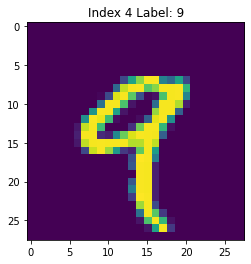

In [14]:
# see the training image and it's label
display_image(train_data, train_labels, 4)

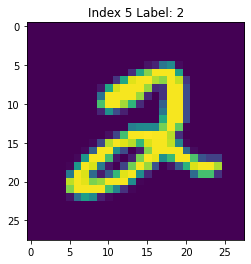

In [15]:
display_image(train_data, train_labels, 5)

Let's identify how many labels we have in our training set and their corresponding images.

In [16]:
train_label_counts = np.unique(train_labels, return_counts=True)
train_label_df = pd.DataFrame({"Label": train_label_counts[0], "Count":train_label_counts[1]})
train_label_df

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


It says, Digit `1` has 6742 samples, `2` has 5958, `3` has 6131 samples and so on... available in training dataset.

So these are basically our classnames for multi-class classification problem.

In [17]:
class_names = train_label_df["Label"]

In [19]:
class_names[1]

1

Also by observing the data it looks like that it's already converted into numbers and it's ready to fit in into the model.


### Split the data into 3 set (Training, Validation and Test)

It's a good practice in order to build our model, we should split the samples into 3 sets, (Training, Validation and Test set).

Since we already have the test set available, so we only need to divide the validation test which we split it from training samples.

* Training Samples : (48K)
* Validation Samples : (12K)
* Test Samples : (10K)

In [20]:
# importing train test split library from scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, random_state=17)

In [21]:
# see the number of splitted data
X_train.shape[0], X_valid.shape[0]

(48000, 12000)

and now if we compare the lables in each set, after splitting

In [22]:
np.unique(y_train, return_counts=True), np.unique(y_valid, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([4719, 5380, 4754, 4956, 4686, 4301, 4734, 5047, 4620, 4803])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1204, 1362, 1204, 1175, 1156, 1120, 1184, 1218, 1231, 1146])))

We have good amount of data to train our model and then validate it using validation set.

## Modelling

We're dealing with Multi-class classification problem, so we might need to take care of few things to build our neural network model,

* **Creating a model**: piece together the layers of neural network(using the functional or Sequential API) or import a previously built model(known as transfer learning).
  * **Input shape**: We will have to deal with 28 x 28 tensors (height and width of an image)
  * **Output shape**: 10, since we have 10 `class_names`(*digits*) to identify
  * **Input Activation function**: Since this is non-linear data, se we'll use non-linear activations like reLu, Softmax, Sigmoid
  * **Output Activation function**: For classification problems, two common functions are Sigmoid and Softmax, since this is a multi-class so we should use *Softmax*
    - **Softmax** : It converts all the output vector into probabilities that the sum of all the probabilities is equal to 1. Kind of argmax, but softer version.
* **Compiling a model**: defining how a model's performance should be measured(loss/metrics) as well as defining how it should improve(optimizer).
  * **Loss function**: We have to use **CategoricalCrossentropy** or **SparseCategoricalCrossentropy** for multi-class classification problem.
    - We will use the later, i.e *SparseCategoricalCrossentropy* since the other one takes encoded inputs, and we are not `one_hot` encoding our training data.
  * **Optimizer**: We can choose from SGD or Adam optimizer functions
  * **Metrics**: For a classification problem, there are many metrics but by default let's see `accuracy`. How accurate our model is performing.
* **Fitting a model**: Letting the model try to find patterns in the data

Let's see how it'll go.

### Default Model

In [43]:
# set the random seed
tf.random.set_seed(17)

# 1. Create a model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), # input shape define
    tf.keras.layers.Dense(4, activation='relu'), # Hidden layer 1 with 4 neurons
    tf.keras.layers.Dense(4, activation='relu'), # Hidden layer 2 with 4 neurons
    tf.keras.layers.Dense(10, activation='softmax') # Output layer, since shape is 10 so 10 neurons.
])

# 2. Compiling a model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 3. Fitting a model
history_1 = model_1.fit(X_train, 
            y_train, 
            epochs = 20, 
            validation_data=(X_valid, y_valid))

Epoch 1/20
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3384 - accuracy: 0.1562 - val_loss: 1.9453 - val_accuracy: 0.2059
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.8860 - accuracy: 0.2173 - val_loss: 1.8386 - val_accuracy: 0.2477
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.7600 - accuracy: 0.2725 - val_loss: 1.6868 - val_accuracy: 0.2825
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.6135 - accuracy: 0.3251 - val_loss: 1.5253 - val_accuracy: 0.3722
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 1.4784 - accuracy: 0.4133 - val_loss: 1.4424 - val_accuracy: 0.4397
Epoch 6/20
1500/1500 [==============================] - 5s 3ms/step - loss: 1.4167 - accuracy: 0.4407 - val_loss: 1.3916 - val_accuracy: 0.4448
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 1.3721 - accuracy: 0.4601 - val_loss: 1.3720 - val_accuracy:

Accuracy on training samples is **66%** and loss is fairly low. But we still need to improve our model to get better `accuracy`.

One more thing we might notice here, `val_accuracy`, these appears in the process of fitting our model, because we passed a parameter i.e `validation_data`.

It gives us the idea of how the model performs on validation set during training the model, it gives us the `val_loss` and `val_accuracy`

Anyways let's improve our model.

## Tuning our Model

A model can tuned/improved in many ways but some common ways we can pass through will be,
* Visualize our inputs, *if normalization needed then normalize it*
* *Adjust the layers and activation function*
* *Tweak optimizer and it's learning rate*
* and Many more..

In [ ]:
### Normalize our inputs
